# LCZ Model Evaluation and Prediction

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

import ee
import geemap
from gee_functions import * # custom functions for GEE
from settings import * # global variables for GEE data download

from IPython.display import Image
import folium

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import requests

import pickle

In [3]:
%load_ext autoreload
%autoreload 2

----

## Model Evaluation

### Load Model

In [ ]:
# load trained model
model_resnet50 = models.load_model('../models/model_resnet50_7')

In [ ]:
# load trained model
model_resnet50_10ch = models.load_model('../models/model_resnet50_10ch_trans_rev_4')

#### Model History

In [132]:
# read in resnet50 performance
resnet50_perf = get_model_history('../models/history_resnet50_?.json')

In [133]:
# read in resnet50_10ch_trans_rev performance
resnet50_10ch_perf = get_model_history('../models/history_resnet50_10ch_trans_rev_?.json')

#### Accuracy

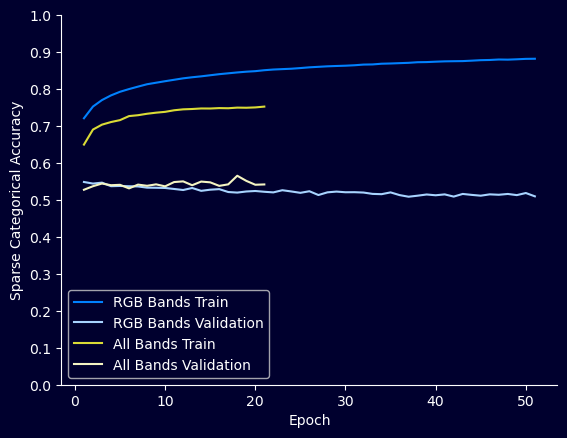

In [135]:
#fig, ax = plt.subplots(figsize=(14, 9))
ax = sns.lineplot(resnet50_perf, x='epoch', y='sparse_categorical_accuracy', label='RGB Bands Train', color='#0081FE')
ax = sns.lineplot(resnet50_perf, x='epoch', y='val_sparse_categorical_accuracy', label='RGB Bands Validation', color='#A7D3FF')

ax = sns.lineplot(resnet50_10ch_perf, x='epoch', y='sparse_categorical_accuracy', label='All Bands Train', color='#DADB36')
ax = sns.lineplot(resnet50_10ch_perf, x='epoch', y='val_sparse_categorical_accuracy', label='All Bands Validation', color='#F4F4C2')

ax.legend()
ax.set_ylabel('Sparse Categorical Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.)
ax.set_yticks(list(np.arange(0., 1.1, 0.1)))

plt.show()

#### Confusion Matrix

In [136]:
%%time
# extract all training labels
images_val, labels_val = tuple(zip(*val_ds))

2023-05-26 08:28:19.824431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-05-26 08:28:19.824837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


CPU times: user 13.1 s, sys: 1.79 s, total: 14.9 s
Wall time: 6.62 s


In [137]:
# convert labels to array and then dataframe
labels_val = np.array(labels_val)
labels_val = pd.DataFrame(labels_val, columns = ['label'])

In [143]:
y_pred = model_resnet50.predict(val_ds).argmax(axis=1)

754/754 [==============================] - 146s 193ms/step


In [189]:
# generate confusion matrix
confusion_matrix = tf.math.confusion_matrix(labels_val,
                                            y_pred,
                                            num_classes=17
                                           ).numpy()

# normalise
cm = normalize(confusion_matrix, norm='l1', axis=0)

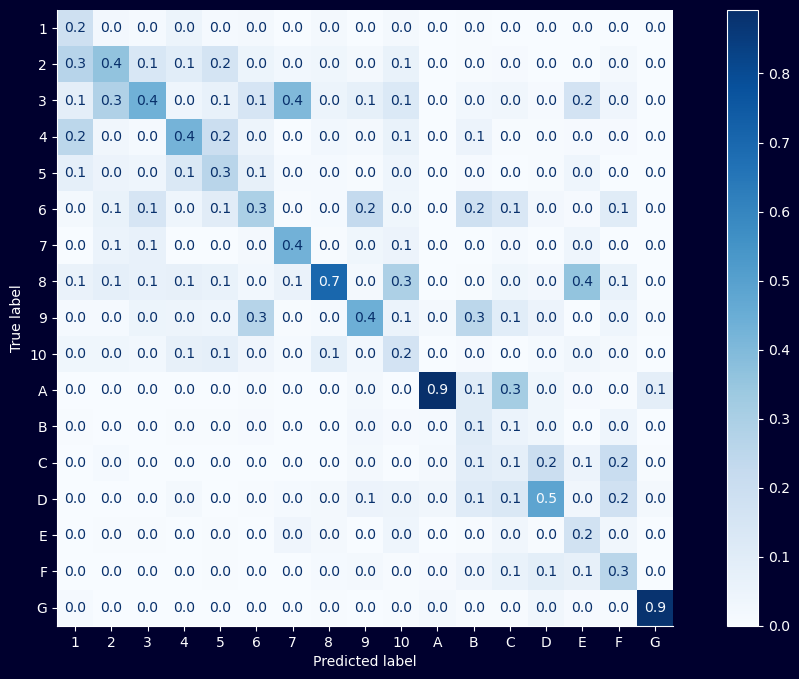

In [190]:
# visualise
cm_disp = ConfusionMatrixDisplay(cm, display_labels=lcz_classes)

fig, ax = plt.subplots(figsize=(14,8))
cm_disp.plot(cmap='Blues', values_format='.1f', ax=ax)

#### Wrong Classifications

In [237]:
# extract conrresponding images
images_val = [np.array(x) for x in list(images_val)]

In [263]:
# define label of interest
loi = 12

In [264]:
# get list of indices that wrongly classified Class 13/B
idx_ = np.where(y_pred==loi)[0]
idx_wrong = np.where(labels_val.to_numpy()[idx_] != loi)[0]

# extract wrong images
images_wrong = [images_val[i] for i in idx_]
images_wrong = [images_wrong[i] for i in idx_wrong]

# extract wrong labels
labels_wrong = [labels_val.to_numpy()[i] for i in idx_]
labels_wrong = [labels_wrong[i] for i in idx_wrong]

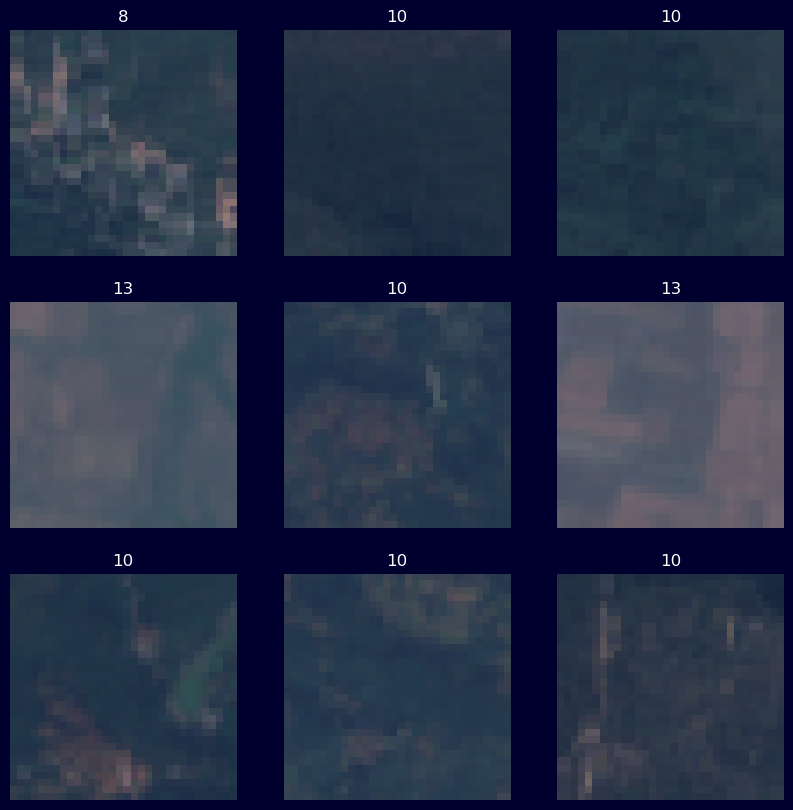

In [265]:
# check out the first 9 images that were wrong
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(images_wrong[:9], labels_wrong[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")


We note that based on overall accuracy, ResNet50 model on RGB values perform better on Validation dataset, so we will use it for predicting LCZ in Singapore's context

----

## Model Prediction

### Load Dataset

In [3]:
#train_df = pd.read_csv('../datasets/airtemp_train.csv')

In [43]:
train_df = pickle.load(open('../datasets/airtemp_train.pkl', 'rb'))

In [92]:
train_df.head()

,index,datetime,longitude,latitude,LST,image,airtemp,id,y_pred_proba,lcz
0,0,2017-06-03 10:42:00,103.849244,1.376444,41.21,[[[[0.1653 0.17695714 0.17614286 0.2155428...,31.2,S109,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.3437000234262086e-...",12
1,1,2018-01-31 10:36:00,103.849244,1.376444,39.39,[[[[0.1653 0.17695714 0.17614286 0.2155428...,28.6,S109,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.3437000234262086e-...",12
2,2,2018-02-05 10:54:00,103.849244,1.376444,33.79,[[[[0.1653 0.17695714 0.17614286 0.2155428...,27.8,S109,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.3437000234262086e-...",12
3,3,2018-02-09 10:24:00,103.849244,1.376444,37.65,[[[[0.1653 0.17695714 0.17614286 0.2155428...,26.8,S109,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.3437000234262086e-...",12
4,4,2018-04-05 10:36:00,103.849244,1.376444,42.65,[[[[0.1653 0.17695714 0.17614286 0.2155428...,29.8,S109,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.3437000234262086e-...",12


In [45]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1247 entries, 0 to 78
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   1247 non-null   datetime64[ns]
 1   longitude  1247 non-null   float64       
 2   latitude   1247 non-null   float64       
 3   LST        1247 non-null   float64       
 4   image      1247 non-null   object        
 5   airtemp    1088 non-null   float64       
 6   id         1247 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 77.9+ KB


### Load Model

In [46]:
model_resnet50 = tf.keras.models.load_model('../models/model_resnet50_7/')

In [47]:
model_resnet50.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 dense_2 (Dense)             (None, 1, 1, 1000)        2049000   
                                                                 
 global_average_pooling2d_1   (None, 1000)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 17)                17017     
                                                                 
Total params: 25,653,729
Trainable params: 2,066,017
Non-trainable params: 23,587,712
_______________________________________

### Data Preprocessing

We need to convert the images from numpy arrays to tensors for the LCZ model to predict

In [79]:
def normalise_rgb(df):
    '''
    Function that takes in dataframe with sentinel-2 reflectance values and convert to rgb values
    '''
    
    # normalise to RGB values
    temp = df.map(lambda x: x[0]*255)
    
    temp = (temp.map(lambda x: x.astype('uint8')) # convert to model dtype
            .map(lambda x: x[:,:,:3][:,:,::-1]) # extracting first 3 bands and reversing the order to align with model specs
           )
    
    return temp
    

In [49]:
def preproc_sen2rgb(df):
    '''
    Function that takes in the 'image' dataframe, preprocesses it into tensors for model that predicts on sen2 rgb data 
    '''
    
    # normalise to RGB values
    temp = normalise_rgb(df)
    
    # convert to tensors
    temp = temp.map(lambda x: tf.convert_to_tensor(x)) 
    
    # convert to tensor iterator
    temp = tf.data.Dataset.from_tensor_slices(temp.to_list())
    
    # define batch size, as the model was trained in batches
    temp = temp.batch(batch_size=1)
    
    return temp
    

In [90]:
def preproc_sen2all(df):
    '''
    Function that takes in the 'image' dataframe, preprocesses it into tensors for model that predicts on sen2 all data 
    '''
    
    # normalise to RGB values
    temp = df.map(lambda x: x[0]*255)
    
    # convert dtype to float32
    temp = temp.map(lambda x: x.astype('float32'))
    
    # convert to tensors
    temp = temp.map(lambda x: tf.convert_to_tensor(x)) 
    
    # convert to tensor iterator
    temp = tf.data.Dataset.from_tensor_slices(temp.to_list())
    
    # define batch size, as the model was trained in batches
    temp = temp.batch(batch_size=1)
    
    return temp
    

In [78]:
# preprocess sentinel-2 images for model prediction
# for sen2 rgb dataset
images = preproc_sen2rgb(train_df['image'])
# for sen2 all dataset
# images = preproc_sen2all(train_df['image'])

### Prediction

We run the LCZ predictions and feed it back into the dataframe

In [82]:
# run predictions
y_pred_prob = model_resnet50.predict(images)
y_pred = y_pred_prob.argmax(axis=1)

2023-05-21 02:26:45.090210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [1247,32,32,3]
	 [[{{node Placeholder/_0}}]]


1247/1247 [==============================] - 98s 78ms/step


In [83]:
# insert predictions and probabilities into dataframe
train_df['y_pred_proba'] = y_pred_prob.tolist()
train_df['lcz'] = y_pred

In [84]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index         1247 non-null   int64         
 1   datetime      1247 non-null   datetime64[ns]
 2   longitude     1247 non-null   float64       
 3   latitude      1247 non-null   float64       
 4   LST           1247 non-null   float64       
 5   image         1247 non-null   object        
 6   airtemp       1088 non-null   float64       
 7   id            1247 non-null   object        
 8   y_pred_proba  1247 non-null   object        
 9   lcz           1247 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 97.5+ KB


In [86]:
# convert dtype for lcz to category
train_df = train_df.astype({'lcz': 'category'})

In [88]:
train_df['lcz'].value_counts()

13    397
8     370
10    275
5     140
12     65
Name: lcz, dtype: int64

Observation:

- Note that there are only 5 LCZs identified, 3 of each are urban and 2 are rural
- This suggests weather stations tend to be in these locations and none are in dense urban areas
- Empirically, this is true
- However, this complicates our efforts to use LCZ for air temperature prediction because the airtemp prediction for dense urban areas will be lower than actual because UHI effects are not factored in

### Save Data

In [89]:
pickle.dump(train_df, open('../datasets/airtemp_train_full.pkl', 'wb'))

In [43]:
# load dataset - specify split if need to split into train and validation
train_ds, val_ds = tfds.load('so2sat/all', split=['train','validation'], download=False)

In [85]:
for i in val_ds.take(1).as_numpy_iterator():
    print(i)

{'label': 7, 'sample_id': 2308, 'sentinel1': array([[[ 1.39654264e-01, -3.32510145e-03,  1.86205685e-01, ...,
          1.21027172e-01,  1.68268308e-02, -1.45496372e-02],
        [-3.12561899e-01, -1.06404051e-01,  3.45813155e-01, ...,
          2.90047675e-01, -4.34038490e-02, -8.03805795e-03],
        [ 5.98527305e-02, -1.46306679e-01, -1.56282127e-01, ...,
          2.96074301e-01, -3.96386757e-02,  1.75721981e-02],
        ...,
        [ 1.49657831e-01,  2.99315676e-02, -2.82687038e-01, ...,
          1.21298361e+00,  8.27778727e-02,  7.47730508e-02],
        [ 1.86241806e-01,  1.09749630e-01, -2.49430984e-01, ...,
          5.71218133e-01, -1.39555588e-01,  1.40833557e-01],
        [ 4.32350300e-02,  2.99319446e-01,  2.29478240e-01, ...,
          3.74317735e-01, -1.60352066e-01,  6.13026656e-02]],

       [[-1.13053456e-01, -7.64773339e-02,  7.51472950e-01, ...,
          4.22966182e-01, -1.21140080e-02, -5.08216843e-02],
        [ 1.82881966e-01,  3.62438798e-01, -1.09729178e-01

2023-05-20 14:37:59.985871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [16]
	 [[{{node Placeholder/_2}}]]
2023-05-20 14:37:59.986351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [16]
	 [[{{node Placeholder/_1}}]]


In [8]:
ee.Initialize()

In [9]:
singapore_bounds = ee.FeatureCollection('USDOS/LSIB/2017').filter(ee.Filter.eq('COUNTRY_NA', 'Singapore'))

sen2 = get_s2_w_cloud_prob(singapore_bounds,
                           datetime.strftime(datetime.strptime(ORIGIN_DATE, '%Y-%m-%d')-relativedelta(months=9), '%Y-%m-%d'), 
                           FINAL_DATE)
image = get_sen2_composite_img(sen2, '2019-01-05')

In [10]:
image = convert_img_to_np(image, get_tile(ee.Geometry.Point([103.8,1.41]), SEN2_TILESIZE-10))

In [11]:
image

array([[[1245.75      , 1365.5       , 1199.5       , ...,
         3841.        , 2180.75      , 1501.75      ],
        [1248.75      , 1402.        , 1212.5       , ...,
         3841.        , 2180.75      , 1501.75      ],
        [1262.5       , 1395.5       , 1209.5       , ...,
         3780.75      , 2233.        , 1528.5       ],
        ...,
        [1677.        , 1764.66666667, 1558.83333333, ...,
         4272.33333333, 2570.5       , 1782.83333333],
        [1684.83333333, 1771.33333333, 1535.83333333, ...,
         4303.16666667, 2542.33333333, 1781.16666667],
        [1693.66666667, 1811.66666667, 1532.66666667, ...,
         4303.16666667, 2542.33333333, 1781.16666667]],

       [[1250.75      , 1385.5       , 1207.75      , ...,
         3841.        , 2180.75      , 1501.75      ],
        [1262.75      , 1407.        , 1210.5       , ...,
         3841.        , 2180.75      , 1501.75      ],
        [1264.25      , 1392.75      , 1204.        , ...,
         3780.